In [25]:
import numpy as np
import matplotlib.pyplot as plt
import wf_psf as wf_psf
from tqdm import tqdm
from joblib import Parallel, delayed, cpu_count, parallel_backend
from wf_psf.utils.utils import zernike_generator
from wf_psf.sims.SimPSFToolkit import SimPSFToolkit
from wf_psf.psf_models.tf_layers import TF_poly_Z_field

import sys
import time

In [30]:
# Paths
wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'
output_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/output/'
# SED folder path
# SED_path = '/feynman/work/dap/lcs/ec270266/wf-psf/data/SEDs/save_SEDs/'
# SED_path = '/feynman/home/dap/lcs/as274094/work/wf-psf/data/SEDs/save_SEDs/'
SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Output saving path (in node05 of candide or $WORK space on feynman)
# output_folder = '/feynman/work/dap/lcs/ec270266/output/interp_SEDs/'
output_folder = output_dir+'psf_dataset1/'

# Reference dataset PATH
# reference_data = '../interp_SED_data/reference_dataset/'
reference_data = wf_psf_dir+'data/coherent_euclid_dataset/'
ref_train = 'train_Euclid_res_2000_TrainStars_id_001.npy'
ref_test  = 'test_Euclid_res_id_001.npy'
selected_id_SED_path = 'selected_id_SED.npy'

# Number of cpus to use for parallelization
#n_cpus = 512 #verify that it doesn't reach the N of actual CPUs
n_cpus = 10

# Save output prints to logfile
old_stdout = sys.stdout
log_file = open(output_folder + 'output.log','w')
sys.stdout = log_file
print('Starting the log file.')

# Dataset ID
dataset_id = 1
dataset_id_str = '%03d'%(dataset_id)

# This list must be in order from bigger to smaller
n_star_list = [52]
n_test_stars = 20
# Total stars
n_stars = n_star_list[0] + n_test_stars
# Max train stars
tot_train_stars = n_star_list[0]

# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 100 
auto_init = False
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms = 0.1
output_dim = 32
LP_filter_length = 2
euclid_obsc = True

# Values for getting 3xEuclid_resolution PSFs outputs.
original_out_Q = output_Q
original_out_dim = output_dim
super_out_Q = 1
super_out_res = 64

# Desired WFE resolutions
WFE_resolutions = [256]

print('\nInit dataset generation')

In [31]:
#zernikes_multires = []
sim_PSF_toolkit_multires = []
#gen_poly_fieldPSF_multires = []

for i, pupil_diameter_ in tqdm(enumerate(WFE_resolutions)):

    # # Generate Zernike maps in max resolution
    # zernikes_multires.append(
    #     zernike_generator(
    #         n_zernikes=max_order,
    #         wfe_dim=pupil_diameter_
    #     )
    # )
    
    # Initialize PSF simulator for each cpu available 
    # (no euclid obscurations and wfr_rms init)
    packed_PSFToolkit = [SimPSFToolkit(
        #zernikes_multires[i],
        max_order=max_order,
        max_wfe_rms=max_wfe_rms,
        oversampling_rate=oversampling_rate,
        output_Q=output_Q,
        output_dim=output_dim,
        pupil_diameter=pupil_diameter_,
        euclid_obsc=euclid_obsc,
        LP_filter_length=LP_filter_length
    ) for j in range(n_cpus)]
    sim_PSF_toolkit_multires.append(packed_PSFToolkit)

    # Initialize one PSF field for each resolution
    # packed_polyField_PSF = [wf_psf.GenPolyFieldPSF(
    #     sim_PSF_toolkit_multires[i][j],
    #     d_max=d_max,
    #     grid_points=grid_points,
    #     max_order=max_order,
    #     x_lims=x_lims,
    #     y_lims=y_lims,
    #     n_bins=n_bins,
    #     lim_max_wfe_rms=max_wfe_rms,
    #     auto_init=auto_init,
    #     verbose=verbose
    # ) for j in range(n_cpus)]
    # gen_poly_fieldPSF_multires.append(packed_polyField_PSF)
    

# # Dummy SimPSFToolkit to init obscurations
# init_toolkit = []
# init_polyField = []
# for i, pupil_diameter_ in enumerate(WFE_resolutions):
#     init_toolkit.append( wf_psf.SimPSFToolkit(
#         zernikes_multires[i], max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
#         output_Q=output_Q, output_dim=output_dim, pupil_diameter=pupil_diameter_, euclid_obsc=euclid_obsc,
#         LP_filter_length=LP_filter_length) )
#     init_polyField.append( wf_psf.GenPolyFieldPSF(init_toolkit[i], d_max=d_max,
#         grid_points=grid_points, max_order=max_order,
#         x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
#         lim_max_wfe_rms=max_wfe_rms, auto_init=True, verbose=verbose))

# # Share C_poly coefficients throughout all the different resolution models
# for i in range(len(gen_poly_fieldPSF_multires)):
#     for j in range(n_cpus):
#         gen_poly_fieldPSF_multires[i][j].set_C_poly(init_polyField[0].C_poly)
#         gen_poly_fieldPSF_multires[i][j].set_WFE_RMS(init_polyField[0].WFE_RMS)
#         gen_poly_fieldPSF_multires[i][j].sim_psf_toolkit.obscurations = init_toolkit[i].obscurations

Z_field = TF_poly_Z_field(
    x_lims=x_lims,
    y_lims=y_lims,
    n_zernikes=max_order,
    d_max=d_max,)

# Load the SEDs
stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)

# Load reference dataset
train_dataset_ref = np.load(reference_data+ref_train, allow_pickle=True)[()]
test_dataset_ref = np.load(reference_data+ref_test, allow_pickle=True)[()]

'''
# Load all the stars positions
pos_np = np.vstack((train_dataset_ref['positions'],test_dataset_ref['positions']))

# Assign preselected SEDs
selected_id_SED = np.load(reference_data+'selected_id_SED.npy', allow_pickle=True)
SED_list = []
for it in range(n_stars):
    concat_SED_wv = np.concatenate((
        stellar_lambdas.reshape(-1,1),
        stellar_SEDs[selected_id_SED[it],:].reshape(-1,1)
    ), axis=1)
    SED_list.append(concat_SED_wv)
'''
    

# Choose the locations randomly
pos_np = np.random.rand(n_stars, 2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]    

# Select random SEDs
SED_list = []
SED_id_list = []
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((
        stellar_lambdas.reshape(-1,1),
        stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_id_list.append(selected_id_SED)
    SED_list.append(concat_SED_wv)
        


# Load and assign the C_poly matrix
C_poly = train_dataset_ref['C_poly']
Z_field.assign_coeff_matrix(C_poly)

# for i in range(len(gen_poly_fieldPSF_multires)):
#     for j in range(n_cpus):
#         gen_poly_fieldPSF_multires[i][j].set_C_poly(C_poly)

print('\nStar positions selected')


1it [00:00,  1.01it/s]


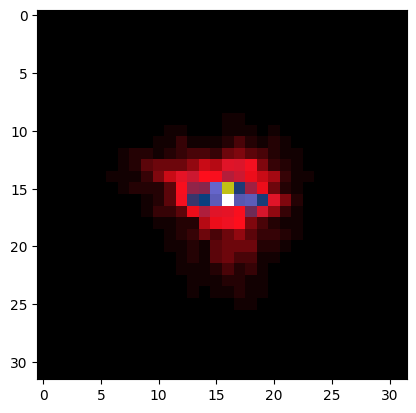

In [32]:
star_id = 4
sim_PSF_toolkit_multires[0][0].set_z_coeffs(Z_field(pos_np)[star_id,:,0,0].numpy().tolist())
psf_test = sim_PSF_toolkit_multires[0][0].generate_poly_PSF(SED_list[star_id], n_bins)
plt.imshow(psf_test,cmap='gist_stern')

In [33]:

#######################################
#            PARALELLIZED             #
#######################################

# Total number of stars
n_procs = n_stars*len(WFE_resolutions)

# Print some info
cpu_info = ' - Number of available CPUs: {}'.format(n_cpus)
proc_info = ' - Total number of processes: {}'.format(n_procs)
print(cpu_info)
print(proc_info)

# Generate star list
star_id_list = [id_ for id_ in range(n_stars)]


# Function to get (i,j) from id
def unwrap_id(id, n_cpus):
    i = int(id/n_cpus)
    j = int(id - i * n_cpus)
    return i, j

def print_status(star_id, i, j):
    print('\nStar ' +str(star_id)+ ' done!' + '   index=('+str(i)+','+str(j)+')')

# Get batches from a list
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# Function to get one PSF
def simulate_star(star_id, sim_PSF_toolkit_multires,i):
    i_,j_ = unwrap_id(star_id, n_cpus)
    _zernike = Z_field(pos_np)[star_id,:,0,0].numpy().tolist()
    sim_PSF_toolkit_multires[i][j_].set_z_coeffs(_zernike)
    _psf = sim_PSF_toolkit_multires[i][j_].generate_poly_PSF(SED_list[star_id], n_bins)
    # _psf, _zernike, _ = sim_PSF_toolkit_multires[i][j_].generate_poly_PSF(
    #     xv_flat=pos_np[star_id, 0],
    #     yv_flat=pos_np[star_id, 1],
    #     SED=SED_list[star_id]
    # )
    # Change output parameters to get the super resolved PSF
    sim_PSF_toolkit_multires[i][j_].output_Q = super_out_Q
    sim_PSF_toolkit_multires[i][j_].output_dim = super_out_res
    super_psf = sim_PSF_toolkit_multires[i][j_].generate_poly_PSF(SED_list[star_id], n_bins)
    # super_psf, _, _ = gen_poly_fieldPSF_multires[i][j_].get_poly_PSF(
    #     xv_flat=pos_np[star_id, 0],
    #     yv_flat=pos_np[star_id, 1],
    #     SED=SED_list[star_id]
    # )
    # Put back original parameters
    sim_PSF_toolkit_multires[i][j_].output_Q = original_out_Q
    sim_PSF_toolkit_multires[i][j_].output_dim = original_out_dim
    #print_status(star_id, i, star_id)
    return (star_id, _psf, _zernike, super_psf)

# Measure time
start_time = time.time()

zernike_coef_multires = []
poly_psf_multires = []
index_multires = []
super_psf_multires = []

for i in range(len(WFE_resolutions)):
    index_i_list = []
    psf_i_list = []
    z_coef_i_list = []
    super_psf_i_list = []
    for batch in chunker(star_id_list, n_cpus):
        with parallel_backend("loky", inner_max_num_threads=1):
            results = Parallel(n_jobs=n_cpus, verbose=100)(delayed(simulate_star)(_star_id, sim_PSF_toolkit_multires,i)
                                                for _star_id in batch)
        index_batch,psf_batch,z_coef_batch,super_psf_batch = zip(*results)
        index_i_list.extend(index_batch)
        psf_i_list.extend(psf_batch)
        z_coef_i_list.extend(z_coef_batch)
        super_psf_i_list.extend(super_psf_batch)

    index_multires.append(np.array(index_i_list) )
    poly_psf_multires.append(np.array( psf_i_list)) 
    zernike_coef_multires.append(np.array(z_coef_i_list))
    super_psf_multires.append(np.array(super_psf_i_list))

end_time = time.time()
print('\nAll stars generated in '+ str(end_time-start_time) +' seconds')

#######################################
#            END PARALLEL             #
#######################################


/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

Fo

In [34]:

# Add noise to generated train star PSFs and save datasets

# SNR varying randomly from 50 to 400 - shared over all WFE resolutions
rand_SNR_train = (np.random.rand(tot_train_stars) * 350) + 50
# Copy the training stars
train_stars = np.copy(np.array(poly_psf_multires[0])[:tot_train_stars, :, :])
# Add Gaussian noise to the observations
noisy_train_stars = np.stack([wf_psf.utils.utils.add_noise(_im, desired_SNR=_SNR) 
                              for _im, _SNR in zip(train_stars, rand_SNR_train)], axis=0)
# Generate Gaussian noise patterns to be shared over all datasets (but not every star)
noisy_train_patterns = noisy_train_stars - train_stars


# Add noise to generated test star PSFs and save datasets

# SNR varying randomly from 20 to 400 - shared over all WFE resolutions
rand_SNR_test = (np.random.rand(n_test_stars) * 380) + 20
# Copy the test stars
test_stars = np.copy(np.array(poly_psf_multires[0])[tot_train_stars:, :, :])
# Add Gaussian noise to the observations
noisy_test_stars = np.stack([wf_psf.utils.utils.add_noise(_im, desired_SNR=_SNR) 
                              for _im, _SNR in zip(train_stars, rand_SNR_test)], axis=0)
# Generate Gaussian noise patterns to be shared over all datasets (but not every star)
noisy_test_patterns = noisy_test_stars - test_stars


WFE_res_id = 0

# Generate datasets for every WFE resolution
for poly_psf_np, zernike_coef_np, super_psf_np in zip(poly_psf_multires, zernike_coef_multires, super_psf_multires):
    
    # Generate numpy array from the SED list
    SED_np = np.array(SED_list)

    # Add same noise dataset to each WFE-resolution dataset
    noisy_train_stars = np.copy(poly_psf_np[:tot_train_stars, :, :]) + noisy_train_patterns
    noisy_test_stars = np.copy(poly_psf_np[tot_train_stars:, :, :]) + noisy_test_patterns

    # Save only one test dataset
    # Build param dicitionary
    dataset_params = {
        'd_max':d_max,
        'max_order':max_order,
        'x_lims':x_lims,
        'y_lims':y_lims,
        'grid_points':grid_points,
        'n_bins':n_bins,
        'max_wfe_rms':max_wfe_rms,
        'oversampling_rate':oversampling_rate,
        'output_Q':output_Q,
        'output_dim':output_dim,
        'LP_filter_length':LP_filter_length,
        'pupil_diameter':WFE_resolutions[WFE_res_id],
        'euclid_obsc':euclid_obsc,
        'n_stars':n_test_stars
    }

    # Save dataset C coefficient matrix (reproductible dataset)
    C_poly = Z_field.get_coeff_matrix()

    test_psf_dataset = {
        'stars' : poly_psf_np[tot_train_stars:, :, :],
        'noisy_stars': noisy_test_stars,
        'super_res_stars' : super_psf_np[tot_train_stars:, :, :],
        'positions' : pos_np[tot_train_stars:, :],
        'SEDs' : SED_np[tot_train_stars:, :, :],
        'zernike_coef' : zernike_coef_np[tot_train_stars:, :],
        'C_poly' : C_poly,
        'parameters': dataset_params,
        'SED_ids':SED_id_list[tot_train_stars:],
        'SNR': rand_SNR_test
    }

    np.save(
        output_folder + 'test_Euclid_res_' + str(n_test_stars) + '_TestStars_id_' + dataset_id_str + 'GT_100_bins.npy',
        test_psf_dataset,
        allow_pickle=True
    )



    # Save the different train datasets
    for it_glob in range(len(n_star_list)):

        n_train_stars = n_star_list[it_glob]

        # Build param dicitionary
        dataset_params = {
            'd_max':d_max,
            'max_order':max_order,
            'x_lims':x_lims,
            'y_lims':y_lims,
            'grid_points':grid_points,
            'n_bins':n_bins,
            'max_wfe_rms':max_wfe_rms,
            'oversampling_rate':oversampling_rate,
            'output_Q':output_Q,
            'output_dim':output_dim,
            'LP_filter_length':LP_filter_length,
            'pupil_diameter':WFE_resolutions[WFE_res_id],
            'euclid_obsc':euclid_obsc,
            'n_stars':n_train_stars
        }

        train_psf_dataset = {
            'stars' : poly_psf_np[:n_train_stars, :, :],
            'noisy_stars': noisy_train_stars[:n_train_stars, :, :],
            'super_res_stars' : super_psf_np[:n_train_stars, :, :],
            'positions' : pos_np[:n_train_stars, :],
            'SEDs' : SED_np[:n_train_stars, :, :],
            'zernike_coef' : zernike_coef_np[:n_train_stars, :],
            'C_poly' : C_poly,
            'parameters': dataset_params,
            'SED_ids' : SED_id_list[:n_train_stars],
            'SNR': rand_SNR_train
        }


        np.save(
            output_folder + 'train_Euclid_res_' + str(n_train_stars) + '_TrainStars_id_' + dataset_id_str + 'GT_100_bins.npy',
            train_psf_dataset,
            allow_pickle=True
        )

    # Next desired resolution   
    WFE_res_id += 1

print('\nDone!')

# Close log file
sys.stdout = old_stdout
log_file.close()